In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [3]:
%matplotlib inline

## Loading and *Normalizing* CIFAR10

<span style="background-color:yellow;">The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].</span>

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

In [6]:
trainset.data.shape

(50000, 32, 32, 3)

In [7]:
len(trainset.targets)

50000

In [8]:
trainloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

In [9]:
trainloader.batch_size

4

In [10]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [11]:
testset.data.shape

(10000, 32, 32, 3)

In [12]:
len(testset.targets)

10000

## Visualize some training images

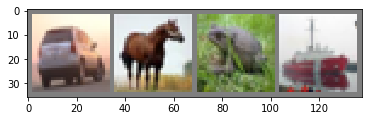

  car horse  frog  ship


In [13]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

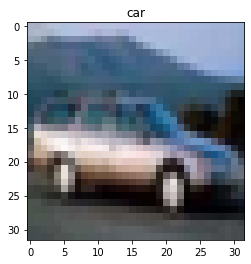

In [14]:
image_idx = 4
plt.imshow(trainset.data[image_idx])
plt.title(classes[trainset.targets[image_idx]])
plt.show()

## Define a CNN

In [15]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [16]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Note:

There is small difference from `Net` model in `pytorch_getstarted.ipynb`. Here, we put a pooling layer in `__init__()` function and applying this pooling layer in `forward()` method twice after each convolution layer. 

This implies that the layer initialization in `__init__` has no order dependence. All the order should be implemented in the `forward()` function.

In [17]:
for p in net.parameters():
    print(p.size())

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


Parameter evolution:

    32 * 32 * 3 --> 28 * 28 * 6 --> 14 * 14 * 6 --> 10 * 10 * 16 --> 5 * 5 * 16 = 400

## Define a loss function and optimizer

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the model

In [19]:
num_batches = trainloader.dataset.data.shape[0] // trainloader.batch_size
num_verbose = 5
num_batches_verbose = num_batches // num_verbose

In [20]:
PATH = './models/cifar_net.pth'
retrain_tag = False

if os.path.exists(PATH) == False or retrain_tag == True:
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        checkpoint_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % num_batches_verbose == num_batches_verbose - 1:    
                print('[%d, %5d] loss: %.3f, time: %.3f secs' %
                      (epoch + 1, 
                       i + 1, 
                       running_loss / num_batches_verbose, 
                       (time.time() - checkpoint_time)))
                running_loss = 0.0
                checkpoint_time = time.time()

    print('Finished Training')
    torch.save(net.state_dict(), PATH)
else:
    net = Net()
    net.load_state_dict(torch.load(PATH))
    print("Model loaded.")

Model loaded.


## Test the model

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 74 %
Accuracy of   car : 76 %
Accuracy of  bird : 28 %
Accuracy of   cat : 48 %
Accuracy of  deer : 29 %
Accuracy of   dog : 42 %
Accuracy of  frog : 68 %
Accuracy of horse : 58 %
Accuracy of  ship : 49 %
Accuracy of truck : 60 %
